# Regression on yacht hydrodynamics data set
> When doing machine learning most of the time is spend collecting and cleaning the data. I decided to do some practicing on some existing open data from Technical University of Delft. The data contain residuary resistance of sailing yachts.

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [machine learning, regression]
- image: https://www.blur.se/images/df4.jpg
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

In [1]:
#hide
import warnings
warnings.filterwarnings("ignore")

![](https://www.blur.se/images/df4.jpg)
I found this open [data](http://archive.ics.uci.edu/ml/datasets/Yacht+Hydrodynamics#) from from Technical University of Delft.

In [2]:
#collapse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import altair as alt
from io import StringIO
import re
import urllib

## 5-Step Systematic Process
I will approach this by trying to following the the following process:
1. Define the Problem
2. Prepare Data
3. Spot Check Algorithms
4. Improve Results
5. Present Results

As described [here]((https://machinelearningmastery.com/process-for-working-through-machine-learning-problems/))





# 1. Define the Problem

### Step 1: What is the problem? Describe the problem informally and formally and list assumptions and similar problems.
To predict the residuary resistance of sailing yachts to be used in the the initial design stage.

### Step 2: Why does the problem need to be solved? List your motivation for solving the problem, the benefits a solution provides and how the solution will be used.
Martin needs practice.

### Step 3: How would I solve the problem? Describe how the problem would be solved manually to flush domain knowledge.
Regression on the Delft data set will be conducted. The regression will be performed initially in the most simplistic way, where each row in the data will be treated as a unique individual. But in reality the rows are of course connected to each other if they are from the same ship. This will maybe be handled at a later stage.


# 2. Prepare Data
I followed a process as described [here](https://machinelearningmastery.com/how-to-prepare-data-for-machine-learning/).

### Step 1: Data Selection: Consider what data is available, what data is missing and what data can be removed.
The Delft data will be used which comprises 308 full-scale experiments, which were performed at the Delft Ship Hydromechanics Laboratory for that purpose. These experiments include 22 different hull forms, derived from a parent form closely related to the Standfast 43 designed by Frans Maas. I think that all of the data can be used

### Step 2: Data Preprocessing: Organize your selected data by formatting, cleaning and sampling from it.

#### Load data

Columns:

| Column | Variable  |Description |
|--------|-----------|------------|
|1.      | lcg       |Longitudinal position of the center of buoyancy, adimensional. |
|2.      | cp        |Prismatic coefficient, adimensional.                           |
|3.      | volume    |Length-displacement ratio, adimensional.                       | 
|4.      | b/d       |Beam-draught ratio, adimensional.                              |
|5.      | l/b       |Length-beam ratio, adimensional.                               |
|6.      | fn        |Froude number, adimensional.                                   |
|7.      | r         |residuary resistance per unit weight of displacement, adimensional|


In [3]:
#collapse
columns = [
'lcg',   
'cp',    
'volume',
'b/d',   
'l/b',   
'fn',    
'r', 
]

data_url = r'http://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data'
with urllib.request.urlopen(data_url) as file:
    s_raw=file.read().decode("utf-8")
    
# remove some dirt:
regexp = re.compile(r' \n', flags=re.DOTALL)
s1 = regexp.sub('\n', s_raw)

regexp = re.compile(r' +', flags=re.DOTALL)
s2 = regexp.sub(' ', s1)
s2[0:200]
s=s2

data = StringIO(s)
data = pd.read_csv(data, sep=' ', encoding='utf-8', names=columns)

features = list(set(columns)-set(['r']))
label = 'r'

X=data[features].copy()
y=data[label].copy()


#### Initial look at data

In [4]:
#hide
data.describe()

,lcg,cp,volume,b/d,l/b,fn,r
count,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000
mean,-2.381818,0.564136,4.788636,3.936818,3.206818,0.287500,10.495357
std,1.513219,0.023290,0.253057,0.548193,0.247998,0.100942,15.160490
min,-5.000000,0.530000,4.340000,2.810000,2.730000,0.125000,0.010000
25%,-2.400000,0.546000,4.770000,3.750000,3.150000,0.200000,0.777500
50%,-2.300000,0.565000,4.780000,3.955000,3.150000,0.287500,3.065000
75%,-2.300000,0.574000,5.100000,4.170000,3.510000,0.375000,12.815000
max,0.000000,0.600000,5.140000,5.350000,3.640000,0.450000,62.420000


In [5]:
#collapse
alt.Chart(data).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative', scale=alt.Scale(zero=False)),
    alt.Y(alt.repeat("row"), type='quantitative'),

).properties(
    width=100,
    height=150
).repeat(
    row=[label],
    column=features,
).interactive()

alt.RepeatChart(...)

### Step 3: Data Transformation: Transform preprocessed data ready for machine learning by engineering features using scaling, attribute decomposition and attribute aggregation.
#### Scaling
The features are already made nondimensional, however it seems that the size of them differ a bit (ex: b/d in [3,5] and cp in [0.5, 0.6] so it might be worth to conduct some kind of more scaling to make them more equal. 

#### Decomposition
This is something that I want to look more into, but not now.
#### Aggregation
No obvious aggregrations here


# 3. Spot Check Algorithms

In [6]:
#collapse
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1)

First just looking at first order linear regression:

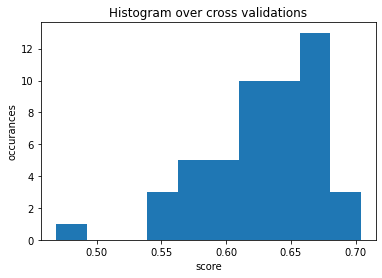

In [7]:
#collapse

linear_regression = LinearRegression()
steps = [
    ('linear_regression', linear_regression),
]

pipeline_linear = Pipeline(steps=steps)

scores = cross_val_score(estimator=pipeline_linear, X=X, y=y, scoring='r2', cv=cv, n_jobs=-1)

fig,ax = plt.subplots()
ax.hist(scores);
ax.set_xlabel('score')
ax.set_ylabel('occurances')
ax.set_title('Histogram over cross validations');

Add a scaler:

In [8]:
#collapse
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

steps = [
    ('scaler', standard_scaler),
    ('linear_regression', linear_regression),
]

pipeline_linear_scaled = Pipeline(steps=steps)

Add polynomial features:

In [9]:
#collapse
from sklearn.preprocessing import PolynomialFeatures

polynomial_features = PolynomialFeatures(degree=2)

steps = [
    ('scaler', standard_scaler),
    ('polynomial_features', polynomial_features),
    ('linear_regression', linear_regression),
]

pipeline_polynomial_scaled = Pipeline(steps=steps)

Add feature selection:

In [10]:
#collapse

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

select_k_best = SelectKBest(score_func=f_regression, k=4)

steps = [
    ('scaler', standard_scaler),
    ('polynomial_features', polynomial_features),
    ('select_k_best', select_k_best),
    ('linear_regression', linear_regression),
]

pipeline_polynomial_scaled_selection = Pipeline(steps=steps)

## Spot checking

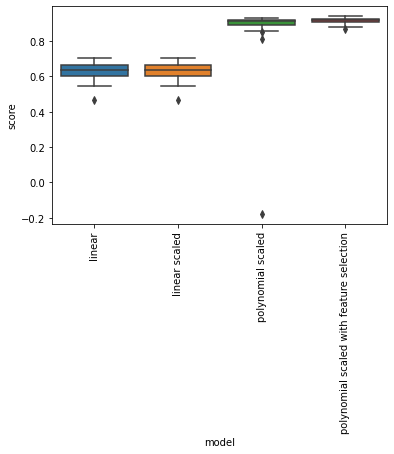

In [11]:
#collapse

models = {
    'linear':pipeline_linear,
    'linear scaled':pipeline_linear_scaled,
    'polynomial scaled':pipeline_polynomial_scaled,
    'polynomial scaled with feature selection':pipeline_polynomial_scaled_selection
         }

scores = {}
for model_name, model in models.items():
    scores[model_name] = cross_val_score(estimator=model, X=X, y=y, scoring='r2', cv=cv, n_jobs=-1)
    
df_cross_validation = pd.DataFrame()

for model_name, model in models.items():

    scores_ = cross_val_score(estimator=model, X=X, y=y, scoring='r2', cv=cv, n_jobs=-1)
    validations = np.arange(0,len(scores_))
    df_=pd.DataFrame()
    df_['validation']=validations
    df_['score']=scores_
    df_['model']=model_name
    df_cross_validation=df_cross_validation.append(df_, ignore_index=True)

df_scores = pd.DataFrame(scores)

ax = sns.boxplot(x='model', y='score', data=df_cross_validation)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

...so the spot checking tells us that it is worth to use:
* A higher order polynomial
* And to do feature selection

# 4. Improve Results

### Algorithm Tuning: 
where discovering the best models is treated like a search problem through model parameter space.

The optimal parameters to the model: *polynomial scaled with feature selection* will be found by conducting a grid search.

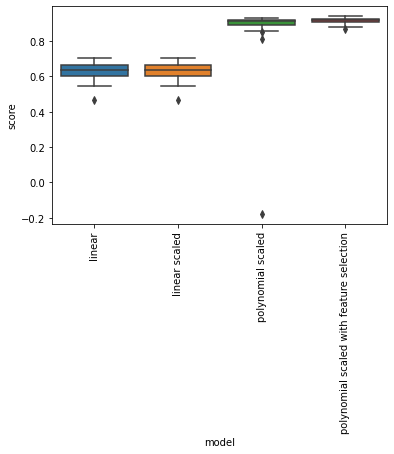

In [12]:
#collapse

df_scores = pd.DataFrame(scores)

ax = sns.boxplot(x='model', y='score', data=df_cross_validation)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

from sklearn.model_selection import GridSearchCV

# define the grid
grid = dict()
grid['select_k_best__k'] = [i for i in range(X.shape[1]-20, X.shape[1]+1)]
grid['polynomial_features__degree'] = [i for i in range(1, 10)]


# define the grid search
search = GridSearchCV(estimator=pipeline_polynomial_scaled_selection, param_grid=grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)
# perform the search
search_result = search.fit(X, y)

In [13]:
model = search_result.best_estimator_
model

Pipeline(steps=[('scaler', StandardScaler()),
                ('polynomial_features', PolynomialFeatures(degree=4)),
                ('select_k_best',
                 SelectKBest(k=6,
                             score_func=<function f_regression at 0x130683400>)),
                ('linear_regression', LinearRegression())])

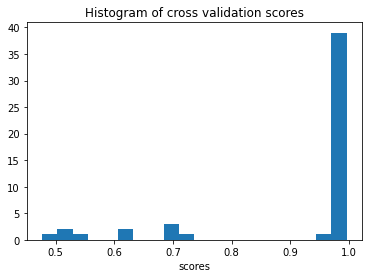

In [14]:
#hide

scores_ = cross_val_score(estimator=model, X=X, y=y, scoring='r2', cv=cv, n_jobs=-1)
fig,ax=plt.subplots()
ax.hist(scores_, bins=20);
ax.set_xlabel('scores');
ax.set_title('Histogram of cross validation scores');

## Ensemble Methods: 
where the predictions made by multiple models are combined.

## Extreme Feature Engineering: 
where the attribute decomposition and aggregation seen in data preparation is pushed to the limits.